In [110]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE

In [111]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX','WILLIAMS','OBV']
ROWS_TO_PREDICT = 32
# one day 16 rows of data

In [112]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-03-17 04:00:00-04:00,152.500000,155.990000,152.500000,155.000000,155.000000,0
2020-03-17 05:00:00-04:00,154.800000,154.990000,149.190000,149.820000,149.820000,0
2020-03-17 06:00:00-04:00,149.320000,149.800000,146.010000,148.600000,148.600000,0
2020-03-17 07:00:00-04:00,149.730000,152.000000,149.500000,151.000000,151.000000,0
2020-03-17 08:00:00-04:00,150.810000,152.400000,147.910000,149.500000,149.500000,0
...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,281.130005,281.559998,278.910004,279.130005,279.130005,2298570
2021-03-16 16:00:00-04:00,279.280000,279.290000,278.780000,279.185000,279.185000,1176864
2021-03-16 17:00:00-04:00,279.130000,281.480000,279.120000,281.125000,281.125000,0


In [113]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-03-17 04:00:00-04:00,152.500000,155.990000,152.500000,155.000000,155.000000,0
2020-03-17 05:00:00-04:00,154.800000,154.990000,149.190000,149.820000,149.820000,0
2020-03-17 06:00:00-04:00,149.320000,149.800000,146.010000,148.600000,148.600000,0
2020-03-17 07:00:00-04:00,149.730000,152.000000,149.500000,151.000000,151.000000,0
2020-03-17 08:00:00-04:00,150.810000,152.400000,147.910000,149.500000,149.500000,0
2020-03-17 09:00:00-04:00,149.430000,150.510000,148.060000,150.490000,150.490000,0
2020-03-17 09:30:00-04:00,150.259995,150.652206,140.000000,146.602707,146.602707,8866104
2020-03-17 10:30:00-04:00,146.589996,151.300003,143.869995,150.000000,150.000000,4780360
2020-03-17 11:30:00-04:00,150.000000,153.940002,148.740005,151.419998,151.419998,4152280


<AxesSubplot:xlabel='Datetime'>

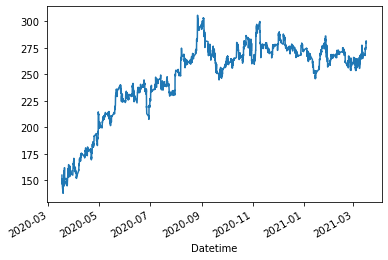

In [114]:
data['close'].plot()

In [115]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """


    data = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    # del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [116]:
data

,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-17 04:00:00-04:00,155.000000,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,475.542379,...,-28.366762,0.000000,155.000000,0.000000,0.000000,0.000000,0.000000,-37.040855,0.000000,0.000000
2020-03-17 05:00:00-04:00,149.820000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,-0.000000,...,-90.735294,0.000000,152.759057,0.000000,0.000000,0.000000,0.000000,-3.341935,-3.399054,-3.341935
2020-03-17 06:00:00-04:00,148.600000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,-0.000000,...,-74.048096,0.000000,150.896648,0.000000,0.000000,0.000000,0.000000,-0.814311,-0.817644,-4.129032
2020-03-17 07:00:00-04:00,151.000000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,-50.000000,0.000000,150.938958,0.000000,0.000000,0.000000,0.000000,1.615074,1.602170,-2.580645
2020-03-17 08:00:00-04:00,149.500000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,-65.030060,0.000000,150.335289,0.000000,0.000000,0.000000,0.000000,-0.993377,-0.998344,-3.548387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,279.130005,2298570,2.924776e+08,128430446,0.140553,1.094642e+06,50.293475,73.364324,50.587366,2173.244932,...,-33.171753,6.988854,278.509790,1.965299,29.219059,14.779179,14.439879,-0.707847,-0.710364,80.083874
2021-03-16 16:00:00-04:00,279.185000,1176864,2.931699e+08,129607310,0.105939,9.475103e+05,47.555953,-52.002637,37.763616,-16038.488150,...,-32.565681,6.499151,278.545119,1.803165,23.305977,16.484539,6.821438,0.019702,0.019700,80.119355
2021-03-16 17:00:00-04:00,281.125000,0,2.931699e+08,129607310,0.188929,8.121517e+05,47.555953,-52.002637,37.763616,231.869639,...,-11.185949,6.235594,278.729868,2.409748,12.682692,15.724170,-3.041477,0.694880,0.692477,81.370968


In [117]:
data.columns

Index(['close', 'volume', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend

In [118]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.2:
        return 1
    if row['close_shift'] -row['close']< -1.2:
        return -1
    else:
        return 0

In [119]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-17 04:00:00-04:00,155.000000,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,475.542379,...,0.000000,155.000000,0.000000,0.000000,0.000000,0.000000,-37.040855,0.000000,0.000000,151.419998
2020-03-17 05:00:00-04:00,149.820000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,-0.000000,...,0.000000,152.759057,0.000000,0.000000,0.000000,0.000000,-3.341935,-3.399054,-3.341935,147.404999
2020-03-17 06:00:00-04:00,148.600000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,-0.000000,...,0.000000,150.896648,0.000000,0.000000,0.000000,0.000000,-0.814311,-0.817644,-4.129032,148.449997
2020-03-17 07:00:00-04:00,151.000000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,150.938958,0.000000,0.000000,0.000000,0.000000,1.615074,1.602170,-2.580645,147.610001
2020-03-17 08:00:00-04:00,149.500000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,150.335289,0.000000,0.000000,0.000000,0.000000,-0.993377,-0.998344,-3.548387,149.419998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,279.130005,2298570,2.924776e+08,128430446,0.140553,1.094642e+06,50.293475,73.364324,50.587366,2173.244932,...,6.988854,278.509790,1.965299,29.219059,14.779179,14.439879,-0.707847,-0.710364,80.083874,NaN
2021-03-16 16:00:00-04:00,279.185000,1176864,2.931699e+08,129607310,0.105939,9.475103e+05,47.555953,-52.002637,37.763616,-16038.488150,...,6.499151,278.545119,1.803165,23.305977,16.484539,6.821438,0.019702,0.019700,80.119355,NaN
2021-03-16 17:00:00-04:00,281.125000,0,2.931699e+08,129607310,0.188929,8.121517e+05,47.555953,-52.002637,37.763616,231.869639,...,6.235594,278.729868,2.409748,12.682692,15.724170,-3.041477,0.694880,0.692477,81.370968,NaN


In [120]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-17 04:00:00-04:00,155.000000,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,475.542379,...,155.000000,0.000000,0.000000,0.000000,0.000000,-37.040855,0.000000,0.000000,151.419998,-1
2020-03-17 05:00:00-04:00,149.820000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,-0.000000,...,152.759057,0.000000,0.000000,0.000000,0.000000,-3.341935,-3.399054,-3.341935,147.404999,-1
2020-03-17 06:00:00-04:00,148.600000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,-0.000000,...,150.896648,0.000000,0.000000,0.000000,0.000000,-0.814311,-0.817644,-4.129032,148.449997,0
2020-03-17 07:00:00-04:00,151.000000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,150.938958,0.000000,0.000000,0.000000,0.000000,1.615074,1.602170,-2.580645,147.610001,-1
2020-03-17 08:00:00-04:00,149.500000,0,0.000000e+00,0,0.000000,-0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,150.335289,0.000000,0.000000,0.000000,0.000000,-0.993377,-0.998344,-3.548387,149.419998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,279.130005,2298570,2.924776e+08,128430446,0.140553,1.094642e+06,50.293475,73.364324,50.587366,2173.244932,...,278.509790,1.965299,29.219059,14.779179,14.439879,-0.707847,-0.710364,80.083874,NaN,0
2021-03-16 16:00:00-04:00,279.185000,1176864,2.931699e+08,129607310,0.105939,9.475103e+05,47.555953,-52.002637,37.763616,-16038.488150,...,278.545119,1.803165,23.305977,16.484539,6.821438,0.019702,0.019700,80.119355,NaN,0
2021-03-16 17:00:00-04:00,281.125000,0,2.931699e+08,129607310,0.188929,8.121517e+05,47.555953,-52.002637,37.763616,231.869639,...,278.729868,2.409748,12.682692,15.724170,-3.041477,0.694880,0.692477,81.370968,NaN,0


In [121]:
# Class divide
data['class_column'].value_counts()

 1    1585
-1    1348
 0    1198
Name: class_column, dtype: int64

In [122]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [123]:
data['class_column'].value_counts()

 1    1585
-1    1348
 0    1198
Name: class_column, dtype: int64

In [124]:
train_set

,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-17 04:00:00-04:00,0,0.000000e+00,0,0.000000,0.000000,50.000000,0.000000,0.000000,475.542379,1000.000000,...,0.000000,155.000000,0.000000,0.000000,0.000000,0.000000,-37.040855,0.000000,0.000000,-1
2020-03-17 05:00:00-04:00,0,0.000000e+00,0,0.000000,-0.000000,50.000000,0.000000,0.000000,-0.000000,1000.000000,...,0.000000,152.759057,0.000000,0.000000,0.000000,0.000000,-3.341935,-3.399054,-3.341935,-1
2020-03-17 06:00:00-04:00,0,0.000000e+00,0,0.000000,-0.000000,50.000000,0.000000,0.000000,-0.000000,1000.000000,...,0.000000,150.896648,0.000000,0.000000,0.000000,0.000000,-0.814311,-0.817644,-4.129032,0
2020-03-17 07:00:00-04:00,0,0.000000e+00,0,0.000000,-0.000000,50.000000,0.000000,0.000000,0.000000,1000.000000,...,0.000000,150.938958,0.000000,0.000000,0.000000,0.000000,1.615074,1.602170,-2.580645,-1
2020-03-17 08:00:00-04:00,0,0.000000e+00,0,0.000000,-0.000000,50.000000,0.000000,0.000000,0.000000,1000.000000,...,0.000000,150.335289,0.000000,0.000000,0.000000,0.000000,-0.993377,-0.998344,-3.548387,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 16:00:00-05:00,0,2.891009e+08,115436601,-0.055280,-588065.882127,44.742482,129.256419,-5.464963,1964.033637,1390.467704,...,-2.387331,268.889965,-0.134018,10.012354,11.445013,-1.432659,-0.067055,-0.067077,73.070968,0
2021-03-12 17:00:00-05:00,0,2.891009e+08,115436601,-0.031407,-504056.470394,44.742482,129.256419,-5.464963,0.000000,1390.467704,...,-2.134615,268.871765,-0.037237,0.534367,9.262884,-8.728517,0.070827,0.070802,73.193548,1
2021-03-12 18:00:00-05:00,0,2.891009e+08,115436601,-0.009501,-432048.403195,44.742482,129.256419,-5.464963,0.000000,1390.467704,...,-2.020732,268.865239,-0.743261,-8.127055,5.784896,-13.911952,-0.011175,-0.011176,73.174194,1


In [125]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [126]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
# classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
# classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
# classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
# classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
# classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')
#
# classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
# classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
# classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
classifiers['RandomForestClassifier 52'] = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 53'] = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0,criterion='gini', n_jobs = -1,max_features='log2')
classifiers['RandomForestClassifier 54'] = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0,criterion='entropy', n_jobs = -1,max_features='log2')
# classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
# classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 51'] = RandomForestClassifier(n_estimators=1000, max_depth=1, random_state=0,criterion='entropy', n_jobs = -1)
# classifiers['RandomForestClassifier 52'] = RandomForestClassifier(n_estimators=10000, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
# classifiers['RandomForestClassifier 53'] = RandomForestClassifier(n_estimators=100000, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
# classifiers['RandomForestClassifier 54'] = RandomForestClassifier(n_estimators=1000000, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)

# classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
# classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
# classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
# classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
# #
# classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
# # classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
# classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
# # classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
#
# classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
# classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
# # classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
# classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

In [127]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [128]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))


Calculate:  DecisionTreeClassifier 1
Score:  0.4375
Calculate:  DecisionTreeClassifier 2
Score:  0.1875
Calculate:  DecisionTreeClassifier 3
Score:  0.5
Calculate:  RandomForestClassifier 4
Score:  0.5625
Calculate:  RandomForestClassifier 5
Score:  0.59375
Calculate:  RandomForestClassifier 52
Score:  0.59375
Calculate:  RandomForestClassifier 53
Score:  0.59375
Calculate:  RandomForestClassifier 54
Score:  0.59375
Calculate:  RandomForestClassifier 51
Score:  0.59375
+----+---------------------------+------------+
|    | Classifier type           |   Accuracy |
|----+---------------------------+------------|
|  0 | DecisionTreeClassifier 1  |    0.4375  |
|  1 | DecisionTreeClassifier 2  |    0.1875  |
|  2 | DecisionTreeClassifier 3  |    0.5     |
|  3 | RandomForestClassifier 4  |    0.5625  |
|  4 | RandomForestClassifier 5  |    0.59375 |
|  5 | RandomForestClassifier 52 |    0.59375 |
|  6 | RandomForestClassifier 53 |    0.59375 |
|  7 | RandomForestClassifier 54 |    0.59375 

In [131]:
rfe = RFE(RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1),4)
fited = rfe.fit(x_train, y_train)
rfe

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                     n_jobs=-1, random_state=0),
    n_features_to_select=4)

In [132]:
names = x.columns
columns=[]
for i in range(len(fited.support_)):
    if fited.support_[i]:
        columns.append(names[i])

print("Columns with predictive power:", columns )


Columns with predictive power: ['volume_adi', 'volume_obv', 'volume_vwap', 'volatility_dcl']
